# Metis Practice Take Home

<a id='introduction'></a>
## Introduction

We will be using New York City [CitiBike](https://www.citibikenyc.com/) data for this analysis. CitiBike is New York City's public bike sharing program which opened in May 2013. Bicycles are rented and then returned to various stations located throughout Manhattan, Brooklyn, and Queens. Memberships and various time-limited passes are available for purchase. 

Historical CitiBike useage data can be downloaded [here](https://www.citibikenyc.com/system-data). 

Python libraries should be used to answer all questions except the last one, where any tool(s) can be used. Your analysis should be performed and annotated so that it could easily be handed off to another data scientist in the group.

### [Question 1](#question1)
> * Programmatically acquire, load, and prepare CitiBike data for the year 2015.
> * How many data points are there in the data used for analysis?

### [Question 2](#question2)
> * Plot the distribution of the trip duration.
> * Describe the structure and hypotheses you have about that structure.

### [Question 3](#question3)
> * Make a plot of the total number of trips per hour of the day.
> * What does this plot look like if days are broken into weekdays vs weekends? What does this usage pattern tell you?
> * Find another interesting way to segment all or some of the data. Discuss your findings.

### [Question 4](#question4)
> * There are instances where a bike's next trip originates from a different station than it was returned to for its most recent previous trip. What do you think causes this? 
> * Explore this phenomenon.

### [Question 5](#question5)
> * Build a predictive model(s) for the total number of daily CitiBike trips. This model should include at least some features from an external data source, i.e. that is not included in the CitiBike data.
> * Evaluate your model(s), discuss pros/cons, and alternative approaches.

### [Question 6](#question6)
> * Using the tool of your preference, develop a visualization that displays something interesting about the data.

In [2]:
import requests as req
import zipfile, io, os, shutil, json

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='question1'></a>
## Question 1
[*Return to Introduction*](#introduction)

> * Programmatically acquire, load, and prepare CitiBike data for the year 2015.
> * How many data points are there in the data used for analysis?

### Acquire and load data

In [2]:
base_url = 'https://s3.amazonaws.com/tripdata/'
base_filename = '2015{}-citibike-tripdata'
filelist = []

# download the zipfiles and extract
sess = req.session()

for month in range(1,13):
    filename = base_filename.format(str(month).zfill(2))
    
    if not os.path.exists('./data/' + filename + '.csv'):
        the_url = base_url + filename + '.zip'
        download = sess.get(the_url)
        zipdata = zipfile.ZipFile(io.BytesIO(download.content))
        zipdata.extractall()
        shutil.move(filename + '.csv', './data/' + filename + '.csv')
    
    filelist.append('./data/' + filename + '.csv')
    
    
# load the data
data_list = []
for fil in filelist:
    data_list.append(pd.read_csv(fil))

    
data = pd.concat(data_list).reset_index(drop=True)
del data_list

<a id='q1_clean_timestamps'></a>
### Preparation: cleaning timestamps

There are two different formats used for the time entry in the `starttime` and `stoptime` columns. The later format appears to be the standard `hour:minute:second` format. The correct interpretation of the first format, where only a single colon is used, is less clear but may be `hour:minute`.

In [3]:
data[['starttime','stoptime','tripduration']].iloc[[0,-1]]

,starttime,stoptime,tripduration
0,1/1/2015 0:01,1/1/2015 0:24,1346
9937968,12/31/2015 21:49:19,12/31/2015 21:55:55,395


In [4]:
data['startformat'] = data.starttime.str.findall(r""":""").apply(len)
data['stopformat']  = data.stoptime.str.findall(r""":""").apply(len)

# boolean masks for the two data format types
mask_a1 = (data.startformat == 1)
mask_a2 = (data.startformat == 2)
mask_b1 = (data.stopformat == 1)
mask_b2 = (data.stopformat == 2)

np.float(mask_a1.sum()) / (mask_a1.sum() + mask_a2.sum())

0.17765470993117408

About 18% of the data contains the single colon format and the format is consistent for both the `starttime` and `stoptime` columns.

Verification of the format of the single colon timestamp could be performed by determining how well the calculated time differences agree with the `tripduration` column

In [5]:
# append ":00" to each column that uses the first format
data.loc[mask_a1, 'starttime'] = data.loc[mask_a1, 'starttime'].apply(lambda x: x + ':00')
data.loc[mask_b1, 'stoptime']  = data.loc[mask_b1, 'stoptime'].apply(lambda x: x + ':00')

# convert the time formats
fmt = '%m/%d/%Y %H:%M:%S'
data['starttime'] = pd.to_datetime(data.starttime, format=fmt)
data['stoptime']  = pd.to_datetime(data.stoptime, format=fmt)

# calculate expected time differential
data['calcduration'] = (data.stoptime - data.starttime).dt.total_seconds()

Compare the expected and calculated time differential to verify that the assumption about timeformat is correct.

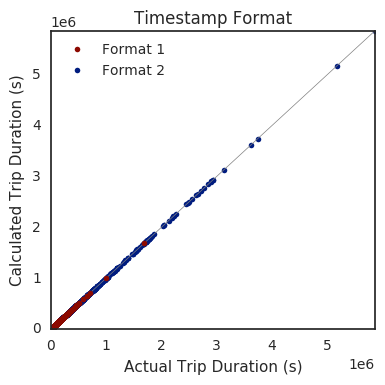

In [6]:
# compare predicted to actual duration via plot
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

colors = sns.color_palette()
blue = colors[0]
red = colors[2]

fig = plt.figure(figsize=(4,4))
ax = plt.axes()

minval = data[['tripduration','calcduration']].min().min()
maxval = data[['tripduration','calcduration']].max().max()

# starttime and stoptime always have the same format for
# a given data point, so this simplifies mask naming
mask1 = mask_a1 | mask_b1
mask2 = mask_a2 | mask_b2

# format 1
ax.plot(data.loc[mask1, 'tripduration'],
        data.loc[mask1, 'calcduration'],
        marker='o', ls='', ms=4, color=red, label='Format 1')

# format 2
ax.plot(data.loc[mask2, 'tripduration'],
        data.loc[mask2, 'calcduration'],
        marker='o', ls='', ms=4, color=blue, label='Format 2', zorder=-1)

# diagonal line
ax.plot([minval, maxval], [minval, maxval], 
        marker='', ls='-', lw=0.5, color='gray', zorder=-1)

ax.set(xlabel='Actual Trip Duration (s)',
       ylabel='Calculated Trip Duration (s)',
       title='Timestamp Format')

ax.get_yaxis().get_major_formatter().set_powerlimits((0, 0))
ax.get_xaxis().get_major_formatter().set_powerlimits((0, 0))

ax.set_xlim(minval, maxval)
ax.set_ylim(minval, maxval)

ax.legend(loc=0)

plt.tight_layout()

The first timestamp format is very likely to be `hours:minutes`. 

<a id='q1_clean_duration'></a>
### Preparation: cleaning trip duration

In [7]:
# check that there are no negative trip durations
assert (data.tripduration < 0).sum() == 0

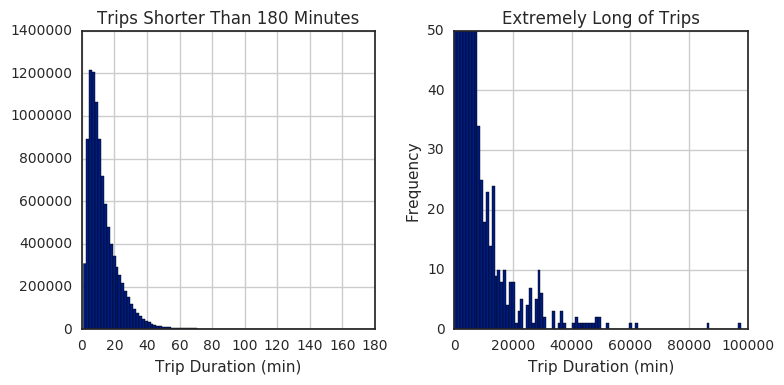

In [8]:
# what does the general distribution and the long tail look like?
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(8,4)

ax = axList[0]
timelim = 3 * 60
mask = (data.tripduration / 60.) <= timelim
_ = (data.loc[mask, 'tripduration'] / 60.).hist(bins=100, ax=ax)
ax.set_xlim(0, timelim)
_ = ax.set(xlabel='Trip Duration (min)', 
           title='Trips Shorter Than {} Minutes'.format(timelim))

ax = axList[1]
_ = (data.tripduration / 60.).hist(bins=100, ax=ax)
ax.set_ylim(0, 50)
_ = ax.set(xlabel='Trip Duration (min)', 
           ylabel='Frequency', 
           title='Extremely Long of Trips')

plt.tight_layout()

The [CitiBike fee schedule](https://www.citibikenyc.com/pricing/annual) is designed for short rides. In fact, signficant fees are incurred for trips longer than 105 minutes. 

As a simple way to clean the data, all trips longer than 3 hours were removed.

In [9]:
mask = (data.tripduration > (3 * 3600.))

orig_shape = data.shape[0]

# the cleaned data
data2 = data[mask.pipe(np.invert)]

assert (data2.shape[0] + mask.sum()) == orig_shape
mask.sum()

29877

This removed about 30,000 trips.

<a id='q1_clean_canceled'></a>
### Preparation: cleaning canceled trips

Trips that were canceled should also be removed. These trips would probably start and end at the same station and be short in duration, say less than 2 minutes. This removes another ~30,000 trips.

In [10]:
mask = ( (data2['start station id'] == data2['end station id']) &
         (data2.tripduration < 120.) )

orig_shape = data2.shape[0]

data2 = data2[mask.pipe(np.invert)]

assert (data2.shape[0] + mask.sum()) == orig_shape

mask.sum()

29345

### Preparation: other cleaning

What other data cleaning and/or sanity checks would you do if you had the time and/or data?

### Number of data entries

The original data contained 9,937,969 rows. This was reduced by < 1% after cleaning to 9,878,747 rows.

In [11]:
data.shape, data2.shape

((9937969, 18), (9878747, 18))

In [12]:
# 0.6% of the data has been removed
1.0 - (data2.shape[0] * 1.0 / data.shape[0])

0.005959165298261682

In [13]:
data2.to_pickle('pkl/data_CLEAN.pkl')

In [3]:
# avoid having to re-run the above steps if kernel is reset
data2 = pd.read_pickle('pkl/data_CLEAN.pkl')

<a id='question2'></a>
## Question 2
[*Return to Introduction*](#introduction)
> * Plot the distribution of the trip duration.
> * Report any structure you find and any hypotheses you have about the structure.

### Fit trip duration distribution

First resample the data in the relevant part of the distribution so the fitting doesn't take so long.

In [195]:
npoints = 20000
nbins = 100

# get the relevant data points
trip_duration = data2.query('tripduration <= 3000.0').tripduration

# sample the distribution so the fits run more quickly
test_dist = np.random.choice(trip_duration, size=npoints, replace=False)

# create the histogram for area normalization
y, x = np.histogram(test_dist, bins=nbins)
x_mid = (x[:-1] + x[1:]) / 2. # position for x is the average of edges
y = y / float(y.sum())  # normalize area

We will fit the distributions two different ways:  

1. manually 
2. automatically, using a library called [fitter](https://github.com/cokelaer/fitter)

Another library that could be useful for this type of task is [powerlaw](https://github.com/jeffalstott/powerlaw).

#### First the manual fitting

In [196]:
# right skewed distributions we are interested in
from scipy.stats import (alpha, betaprime, f, fisk, 
                         gamma, genextreme, invgamma, invweibull,
                         lognorm, mielke, recipinvgauss, wald)

# suppress some warnings from distribution fitting
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# a list of all distributions to fit
dist_list = (alpha, betaprime, f, fisk, 
             gamma, genextreme, invgamma, invweibull,
             lognorm, mielke, recipinvgauss, wald)

# variables for storing output
param_dict = dict()
dist_df = pd.DataFrame({'x':x_mid, 'y':y})

# fit the distributions
for dist in dist_list:
    
    name = dist.name
    
    # fit the new distribution
    param = dist.fit(test_dist)
    
    # store parameters
    param_dict[name] = param
    
    # calculate the area-normalized pdf
    pdf_fitted = dist.pdf(x_mid, *param[:-2], 
                                 loc=param[-2], 
                                 scale=param[-1])
    
    # add the pdf to the dataframe
    dist_df[name] = pdf_fitted
    
    print(name)

alpha
betaprime
f
fisk
gamma
genextreme
invgamma
invweibull
lognorm


/home/ubuntu/miniconda/envs/scienv3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
/home/ubuntu/miniconda/envs/scienv3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


mielke
recipinvgauss
wald


In [197]:
# calculate mean squared error for each distribution
cols = [x for x in dist_df if x not in ['x','y']]

error_df = (dist_df[cols]
            .sub(dist_df['y'], axis=0)
            .pow(2).sum()
            .to_frame()
            .rename(columns={0:'sumsquared_error'})
            .sort_values('sumsquared_error'))

error_df

,sumsquared_error
genextreme,0.020445
invweibull,0.020445
fisk,0.020446
invgamma,0.020446
lognorm,0.020451
mielke,0.020453
alpha,0.020455
betaprime,0.020465
f,0.020469
recipinvgauss,0.020498


Next, the automated method, which uses the fitter library mentioned above.

In [198]:
from fitter import Fitter # a library that determines the best fit distribution

# Fitter will test all distributions in scipy.stats by default
# or a list can be supplied so it goes more quickly
dist_name_list = [x.name for x in dist_list]

fit = Fitter(test_dist, bins=nbins, 
             distributions=dist_name_list, timeout=120)

fit.fit()

Fitted alpha distribution with error=4.783612496885971e-07)
Fitted betaprime distribution with error=2.3586117496439581e-07)
Fitted f distribution with error=2.514329108097482e-07)
Fitted fisk distribution with error=2.9859133409468573e-07)
Fitted gamma distribution with error=3.9280125292684003e-07)
Fitted genextreme distribution with error=3.200648235620481e-07)
Fitted invgamma distribution with error=2.4554502633202033e-07)
Fitted invweibull distribution with error=3.2006480785050387e-07)
Fitted lognorm distribution with error=1.457538815924884e-07)


/home/ubuntu/miniconda/envs/scienv3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
/home/ubuntu/miniconda/envs/scienv3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Fitted mielke distribution with error=3.797204141322121e-07)
Fitted recipinvgauss distribution with error=8.857442026994607e-07)
Fitted wald distribution with error=9.382199257247465e-07)


In [199]:
# mean squared error for each distribution
fitter_error_df = fit.df_errors.sort_values('sumsquare_error')
fitter_error_df

,sumsquare_error
lognorm,1.457539e-07
betaprime,2.358612e-07
invgamma,2.455450e-07
f,2.514329e-07
fisk,2.985913e-07
invweibull,3.200648e-07
genextreme,3.200648e-07
mielke,3.797204e-07
gamma,3.928013e-07
alpha,4.783612e-07


The above distributions clearly produce different error values and sort differently as far as best fit goes, relative to the results obtained manually. That should probably be looked into further when time allows.

### Plot trip duration distribution

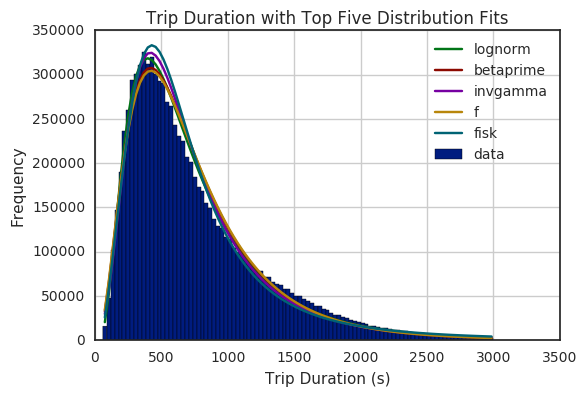

In [200]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

fig = plt.figure(figsize=(6,4))

# get the discrete distribution for calculating best-fit distributions
y,x = np.histogram(trip_duration, bins=nbins)
x_mid = (x[1:] + x[:-1]) / 2.

# plot the data as a histogram
ax = trip_duration.hist(bins=nbins, label='data')

# get the top five distributions from fitter
# and plot an area-corrected pdf
plot_dist = fitter_error_df.iloc[:5].index

for dist in plot_dist:
    params = fit.fitted_param[dist]
    
    plot_pdf = eval(dist).pdf(x_mid, *params)
    norm = y.sum() / plot_pdf.sum()
    plot_pdf *= norm
    
    ax.plot(x_mid, plot_pdf, label=dist)

    
_ = ax.set(xlabel='Trip Duration (s)',
           ylabel='Frequency',
           title='Trip Duration with Top Five Distribution Fits')

_ = ax.legend()
fig.savefig('figures/q2_trip_duration_distribution.png', dpi=300, transparent=True)

The resulting distribution is positively skewed. Conceptually, this makes sense as more bike rides would tend to be of a shorter rather than longer distance. Furthermore, very few people would be likely to rent a bike for extremely short distances rather than walking.

Five candidate distributions consistent with this profile are plotted above. Further analysis could focus on discriminating between these (and possibly other positively skewed) distributions. Powerlaw analysis is another possible method for extending this exploration.

<a id='question3'></a>
## Question 3
[*Return to Introduction*](#introduction)
> * Make a plot of the total number of trips per hour of the day.
> * What does this plot look like if days are broken into weekdays vs weekends? What does this usage pattern tell you?
> * Find another interesting way to segment all or some of the data. Discuss your findings.

In [133]:
# calculate the hour the trip began and ended
data2['starthour'] = data2.starttime.dt.hour
data2['stophour']  = data2.stoptime.dt.hour

In [134]:
# commonly used plotting settings
def hour_fig_setup():
    sns.set_palette('dark')
    sns.set_context('notebook')
    sns.set_style('ticks')

    fig = plt.figure(figsize=(6,4))
    ax = plt.axes()

    return fig, ax
    
def hour_ticks_setup(ax):
    ax.set_xticks(range(0, 24, 4))
    ax.set_xticklabels([str(x)+y for x,y in zip([12,  4,  8, 12,  4,  8], 
                                           sum([['AM']*3, ['PM']*3],[]))])
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    return

<a id='q3_trips_by_hour'></a>
### Trip frequency by hour

As expected, the most trips occur during the daytime hours and their are spike in the trip number in the early morning and evening hours.

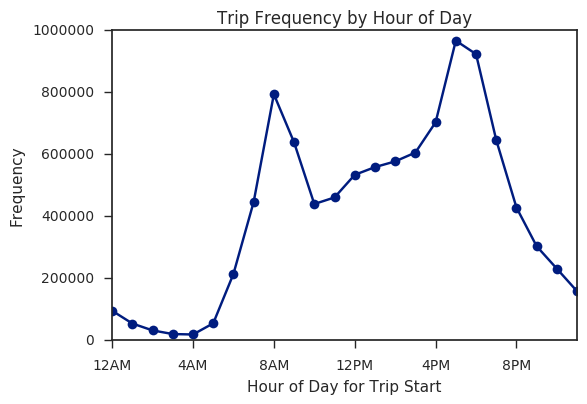

In [135]:
fig, ax = hour_fig_setup()

_ = (data2.starthour
     .value_counts()
     .sort_index()
     .plot(marker='o', ax=ax))

hour_ticks_setup(ax)

_ = ax.set(xlabel='Hour of Day for Trip Start',
           ylabel='Frequency',
           title='Trip Frequency by Hour of Day')

### Trip frequency by hour for weekdays vs weekends

In [136]:
# boolean value for weekdays
data2['startweekday'] = data2.starttime.dt.dayofweek.isin([0,1,2,3,4])
data2['stopweekday']  = data2.stoptime.dt.dayofweek.isin([0,1,2,3,4])

Further segregating the data by weekdays vs weekends shows that CitiBike usage is very popular during morning and evening commute hours for the weekdays. For weekends, the usage peaks around the middle of the day, indicating they may have a more casual use during this time.

In [137]:
plot_data = (data2[['starthour','startweekday']]
             .rename(columns={'startweekday':'weekday'})
             .groupby(['weekday','starthour'])
             .size()
             .reset_index(level=0)
             .pivot(columns='weekday', values=0))

plot_data.head()

weekday,False,True
starthour,,
0,37057,57283
1,25319,27875
2,16447,14512
3,10595,8599
4,6799,10997


<a id='q3_trips_by_hour_day'></a>

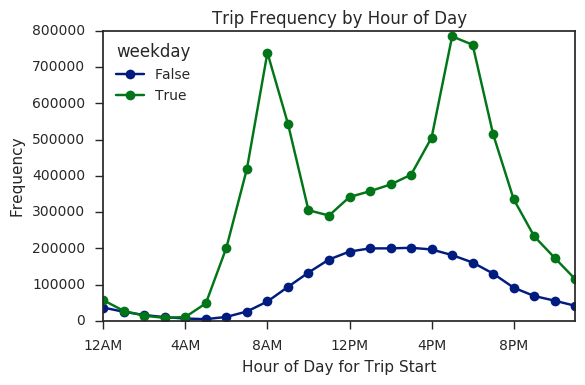

In [138]:
fig, ax = hour_fig_setup()

_ = plot_data.plot(marker='o', ax=ax)

hour_ticks_setup(ax)

_ = ax.set(xlabel='Hour of Day for Trip Start',
           ylabel='Frequency',
           title='Trip Frequency by Hour of Day')

plt.tight_layout()
fig.savefig('figures/q3_trip_frequency_hour_day.png', dpi=300, transparent=True)

<a id='q3_weekday_trips_by_borough'></a>
### Inter-borough weekday trips to/from Manhattan

Another interesting trend to examine is the flow of traffic into and out of Manhattan as a function of weekday hour.

I was unable to find a table of all CitiBike stations with their respective boroughs, so the address was determined based on latitude and longitude.

This required mapping each station to the appropriate borough. The union of the start and end stations was used to create a unique list of all stations with latitude and longitude. The latitude and longitude was then used to determine the zip code and, subsequently, the borough.

The assignment of boroughs could alternatively be performed using a mapping library and a map of New York's borough boundaries.

In [142]:
# find the mean latitude and longitude for each station
stations = (pd.concat([(data2[['start station id', 'start station name',
                               'start station latitude', 'start station longitude']]
                        .rename_axis(lambda x: x.replace('start station ', ''), axis=1)),
                       (data2[['end station id', 'end station name',
                               'end station latitude', 'end station longitude']]
                         .rename_axis(lambda x: x.replace('end station ', ''), axis=1))], 
                      axis=0)
            .groupby(['id', 'name'])
            .mean()
            .reset_index())

# string with combined latitude and longitude that will be used to get address
stations['lat_long'] = stations.apply(lambda x: ','.join([str(x.latitude), 
                                                          str(x.longitude)]),
                                      axis=1)
stations.head(3)

,id,name,latitude,longitude,lat_long
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"40.76727215996669,-73.99392887997087"
1,79,Franklin St & W Broadway,40.719116,-74.006667,"40.719115519960816,-74.00666661001569"
2,82,St James Pl & Pearl St,40.711174,-74.000165,"40.71117416000733,-74.00016544998878"


In [143]:
# find the address of each station using latitude and longitude
# this code is slow to run!
from geopy import geocoders
osm = geocoders.Nominatim()

stations['address'] = stations.lat_long.apply(lambda x: osm.reverse(x).address)

The addresses determined above with geopy do not reliably contain the borough name. However, the zip code is always present, and zip codes are each unique to a single borough. So a table of zip codes and their corresponding borough names was scraped to help with assignment of CitiBike stations.

In [ ]:
# scrape html
tables = pd.read_html('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm')

# convert to table with zip codes and boroughs
zipcodes = tables[0]
zipcodes.columns = zipcodes.loc[0, :].tolist()
zipcodes = zipcodes.iloc[1:].reset_index(drop=True)

# correct table format as data ends up in wrong column
mask = zipcodes['ZIP Codes'].isnull()
zipcodes.loc[mask, 'ZIP Codes'] = zipcodes.loc[mask, 'Neighborhood'].copy()
zipcodes.loc[mask, 'Neighborhood'] = zipcodes.loc[mask, 'Borough'].copy()

zipcodes.loc[mask, 'Borough'] = np.NaN
zipcodes['Borough'] = zipcodes.Borough.fillna(method='ffill')

# extract zipcodes
zipcodes = (pd.merge(zipcodes[['Borough']],
                     (zipcodes['ZIP Codes']
                      .str.extractall(r"""([0-9]{5})""")
                      .reset_index(level=-1, drop=True)),
                     left_index=True, right_index=True)
            .rename(columns={0:'zipcode', 'Borough':'borough'})
            .reset_index(drop=True))

zipcodes.head(3)

In [ ]:
# extract the zip code from the address and join with zip code table to get borough
stations['zipcode'] = stations.address.str.extract(r""" ([0-9]{5}),""", expand=False)
stations = pd.merge(stations, zipcodes, on='zipcode')

stations.to_pickle('pkl/stations.pkl')

stations.head(3)

In [144]:
# run this so addresses don't have to be queried again if the kernel is restarted
stations = pd.read_pickle('./pkl/stations.pkl')

Finally, merge the station and borough information with the data.

In [145]:
# merge to determine borough for start and end location
data2 = (pd.merge(data2, stations[['id','name','borough']],
                  left_on=['start station id', 'start station name'],
                  right_on=['id','name'])
         .rename(columns={'borough':'start station borough'})
         .drop(['id','name'], axis=1))

data2 = (pd.merge(data2, stations[['id','name','borough']],
                  left_on=['end station id', 'end station name'],
                  right_on=['id','name'])
         .rename(columns={'borough':'end station borough'})
         .drop(['id','name'], axis=1))

Select only inter-borough weekday trips.

In [146]:
# boolean selector for weekday inter-borough trips where one of two boroughs is Manhattan
mask_into_manh = (data2.startweekday &
                  (data2['start station borough'] != 'Manhattan') &
                  (data2['end station borough']   == 'Manhattan'))

mask_from_manh = (data2.startweekday &
                  (data2['start station borough'] == 'Manhattan') &
                  (data2['end station borough']   != 'Manhattan'))

In [147]:
plot_data = (pd.concat([data2[mask_into_manh].assign(Direction='Into Manhattan'),
                        data2[mask_from_manh].assign(Direction='From Manhattan')],
                       axis=0)
              .groupby(['starthour','Direction'])
              .size()
              .reset_index(level=-1)
              .pivot(columns='Direction', values=0))

plot_data.head(3)

Direction,From Manhattan,Into Manhattan
starthour,,
0,1809,791
1,948,351
2,438,199


<a id='q3_weekday_trips_by_borough_plot'></a>

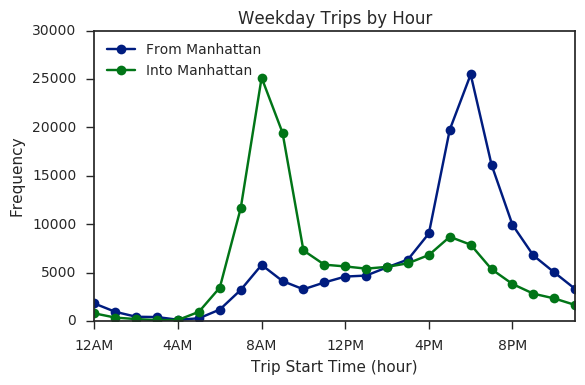

In [148]:
fig, ax = hour_fig_setup()

_ = plot_data.plot(marker='o', ax=ax)

ax.legend(loc=2)

hour_ticks_setup(ax)

_ = ax.set(xlabel='Trip Start Time (hour)',
           ylabel='Frequency',
           title='Weekday Trips by Hour')

plt.tight_layout()
fig.savefig('figures/q3_weekday_trips_by_borough_hour.png', dpi=300, transparent=True)

For weekday trips to/from Manhattan from other boroughs, trips consistent with morning commutes tend to originate outside of Manhattan (Brooklyn and Queens) and end in Manhattan. For the evening commute, a majority of the trips take the opposite path.

<a id='question4'></a>
## Question 4
[*Return to Introduction*](#introduction)
> * There are instances where a bike's next trip originates from a different station than it was returned to for its most recent previous trip. What do you think causes this? 
> * Explore this phenomenon.

<a id='q4_bike_shift calculation'></a>
### Discontinuities in bike location

Discontinuities in the station where a bike was dropped off and the origin of its next trip are likely explained by the transportation of bikes from one station to another. This could be important to ensure bike availability at some stations and eliminate over-crowding at others.

In [149]:
# function to shift each bike's sorted timeseries data 
# by one row so transported bikes can be found
def shift_start(data):
    # sort data and shift start times up a row 
    data = data.sort_values('stoptime')
    
    data['next station id']   = data['start station id'].shift(-1)
    data['next station name'] = data['start station name'].shift(-1)
    data['nextweekday'] = data['startweekday'].shift(-1)
    data['nexthour'] = data['starthour'].shift(-1)
    
    # drop nan row created by shifting start station data
    data = data.dropna(subset=['next station id'])
    data['next station id'] = data['next station id'].astype(np.int)
    
    return data

# dataframe with shifted station data
transports = (data2[['bikeid',
                     'start station id', 'start station name',
                     'end station id', 'end station name',
                     'starttime', 'stoptime', 
                     'startweekday', 'stopweekday',
                     'starthour','stophour']]
              .sort_values('stoptime')
              .groupby('bikeid', as_index=False)
              .apply(lambda x: shift_start(x)))

In [150]:
# select data where bike was moved between subsequent uses
mask = (transports['end station id'] != transports['next station id'])
transports = transports[mask]

In [151]:
# add borough name for end and next station
transports = (pd.merge(transports, stations[['id','name','borough']],
                       left_on=['end station id', 'end station name'],
                       right_on=['id','name'])
              .drop(['name','id'], axis=1)
              .rename(columns={'borough':'end station borough'}))

transports = (pd.merge(transports, stations[['id','name','borough']],
                       left_on=['next station id', 'next station name'],
                       right_on=['id','name'])
              .drop(['name','id'], axis=1)
              .rename(columns={'borough':'next station borough'}))

### Exploring bike transport

Only about 6% of station-to-station transports are between boroughs (i.e. inter-borough transports). Most are within the same borough.

In [152]:
transports['interborough'] = (transports['end station borough'] != 
                              transports['next station borough'])

transports.interborough.sum() * 1.0 / transports.shape[0]

0.063690081518720298

In [153]:
# tally the number of weekend and weekday days for normalization
dates = data2[['stoptime', 'stopweekday']].copy()
dates['stopdate'] = dates.stoptime.dt.date
dates = (dates[['stopdate', 'stopweekday']]
         .drop_duplicates()
         .reset_index(drop=True))

weekdaycount = (dates.stopweekday
                .value_counts()
                .astype(np.float))

weekdaycount

True     262.0
False    104.0
Name: stopweekday, dtype: float64

Most transports within the same borough (intra-borough, average per-day) are within Manhattan and during weekdays. The number of transports for Queens and Brooklyn doesn't change much between weekends and weekdays, although these numbers are quite small to begin with.

In [154]:
# average daily transports within boroughs
((transports
  .query('interborough == False')
  .groupby(['stopweekday','next station borough'])
  .size())
 .div(weekdaycount, axis=0, level=0))

stopweekday  next station borough
False        Brooklyn                 140.538462
             Manhattan               1486.096154
             Queens                     2.951923
True         Brooklyn                 149.137405
             Manhattan               2257.515267
             Queens                     2.507634
dtype: float64

In [155]:
plot_data = (transports
             .query('interborough == False')
             [['stopweekday','stophour','next station borough']]
             .groupby(['stopweekday','stophour','next station borough'])
             .size()
             .reset_index()
             .rename(columns={'stophour':'Hour',
                              'next station borough':'Borough',
                              'stopweekday':'Weekday'})
             .pivot_table(index='Hour', columns=['Borough','Weekday'],
                          values=0, aggfunc=sum)
             .loc[:,slice('Brooklyn','Manhattan')])

plot_data.head(3)

Borough Brooklyn        Manhattan        
Weekday    False  True      False   True 
Hour                                     
0          351.0  520.0    2529.0  5339.0
1          248.0  233.0    1769.0  2566.0
2          147.0  119.0    1096.0  1357.0

<a id='q4_transport_plot'></a>

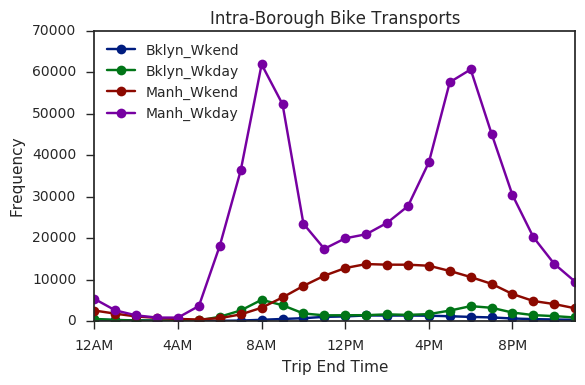

In [156]:
fig, ax = hour_fig_setup()

plot_data.plot(marker='o', ax=ax)

ax.set(xlabel='Trip End Time',
       ylabel='Frequency',
       title='Intra-Borough Bike Transports')

hour_ticks_setup(ax)
_ = ax.legend(loc=2, labels=['Bklyn_Wkend', 'Bklyn_Wkday', 'Manh_Wkend', 'Manh_Wkday'])

plt.tight_layout()
fig.savefig('figures/q4_bike_transport.png', dpi=300, transparent=True)

The transport of bikes between stations is likely used to adjust bike supply given time-dependent traffic flow patterns. Most (~94%) of these bikes are done within a given borough. The above graph indicates these movements mirror peak usage times, as might be expected.

To futher improve this analysis, ideally *per-day* and *% bikes per station* normalized values should be used instead of total counts (frequency). **(TODO)**

<a id='question5'></a>
## Question 5
[*Return to Introduction*](#introduction)
> * Build a predictive model(s) for the total number of daily CitiBike trips. This model should include at least some features from an external data source, i.e. that is not included in the CitiBike data. Weather (see below) is suggested for the external data, but you may use any data that you wish. 
> * Evaluate your model and discuss ways it could be improved.

Hourly weather data for Central Park was downloaded from [NOAA](https://www7.ncdc.noaa.gov/CDO/cdopoemain.cmd?datasetabbv=DS3505&countryabbv=&georegionabbv=NAMER&resolution=40). The data used below can also be downloaded [here](https://goo.gl/3FNvUk). A description of the data fields is also [available](https://www.ncdc.noaa.gov/cdohtml/3505doc.txt).

The models below could be improved in the following ways **(TODO)**:

* incorporating additional data (i.e. other years) so there are more daily data points
* adding data from the weekends, in addition to a boolean feature denoting weekday/weekend
* addition of other features such as holidays

In [157]:
trips_per_day = (data2.loc[data2.startweekday, 'starttime']
                 .dt.date
                 .value_counts()
                 .sort_index()
                 .reset_index()
                 .rename(columns={'index':'date', 'starttime':'trips'}))

trips_per_day['date'] = trips_per_day.date.astype('datetime64[ns]')

Examination the distribution first.

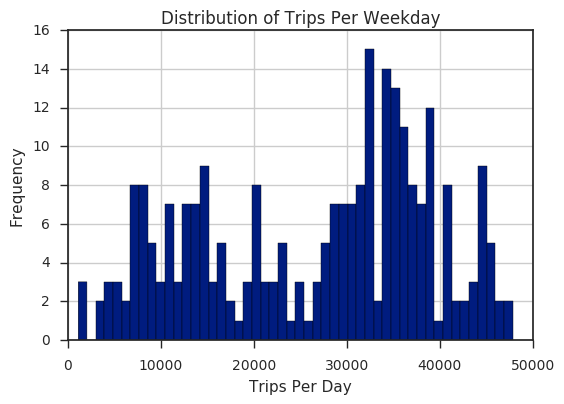

In [158]:
fig, ax = hour_fig_setup()

trips_per_day.hist(bins=50, ax=ax)

ax.set(xlabel='Trips Per Day',
       ylabel='Frequency',
       title='Distribution of Trips Per Weekday')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

Incorporate the weather data.

In [159]:
# import the weather data and clean NaN's
weather = pd.read_csv('./data/nyc_central_park_hourly_weather.txt', sep='\s+')

weather.replace(to_replace=r"""\*{1,4}""", value=np.NaN, regex=True, inplace=True)
weather.dropna(axis=1, how='all', inplace=True)
weather.replace(to_replace=['0.00T'], value=0.0, inplace=True)

# fix column formatting and naming
weather.rename(columns={'YR--MODAHRMN':'DATE'}, inplace=True)
weather['DATE'] = pd.to_datetime(weather.DATE.astype(str) + '00', format='%Y%m%d%H%M%S')

for col in weather.columns:
    if col not in ['DATE','SKC']:
        weather[col] = weather[col].astype(np.float)
        
weather = (weather[['DATE','TEMP', 'SPD', 'GUS', 'PCP01', 'SD']]
           .rename(columns={'DATE':'date', 'TEMP':'temp', 'SPD':'wind',
                            'GUS':'gust', 'PCP01':'precip', 'SD':'snow_depth'}))

In [160]:
# calculate daily sum for precipitation and daily max for other columns
weather_daily = pd.merge((weather[['date','precip']]
                          .set_index('date')
                          .resample('D')
                          .sum()),
                         (weather[['date','temp','wind','gust','snow_depth']]
                          .set_index('date')
                          .resample('D')
                          .max()),
                         left_index=True,
                         right_index=True).reset_index()

weather_daily['snow_depth'] = weather_daily.snow_depth.interpolate()

# either take max of wind/gust or fill gust with wind where empty?
# weather_daily['temp'] = weather_daily[['temp','wind']].max(axis=1)
# weather_daily.drop(['gust'], axis=1, inplace=True)
weather_daily['gust'] = weather_daily.gust.fillna(weather_daily.wind)

Now combine trips with the weather.

In [161]:
trips_weather = pd.merge(trips_per_day,
                         weather_daily,
                         on='date')

Xcol = ['precip', 'temp', 'wind', 'gust', 'snow_depth']

trips_weather[Xcol + ['trips']].head(3)

,precip,temp,wind,gust,snow_depth,trips
0,0.00,39.0,11.0,29.0,0.0,4987
1,0.00,42.0,11.0,23.0,0.0,10503
2,0.08,53.0,18.0,46.0,0.0,13419


Correlations between variables and the predictor are sometimes useful, although we are not using linear regression here.

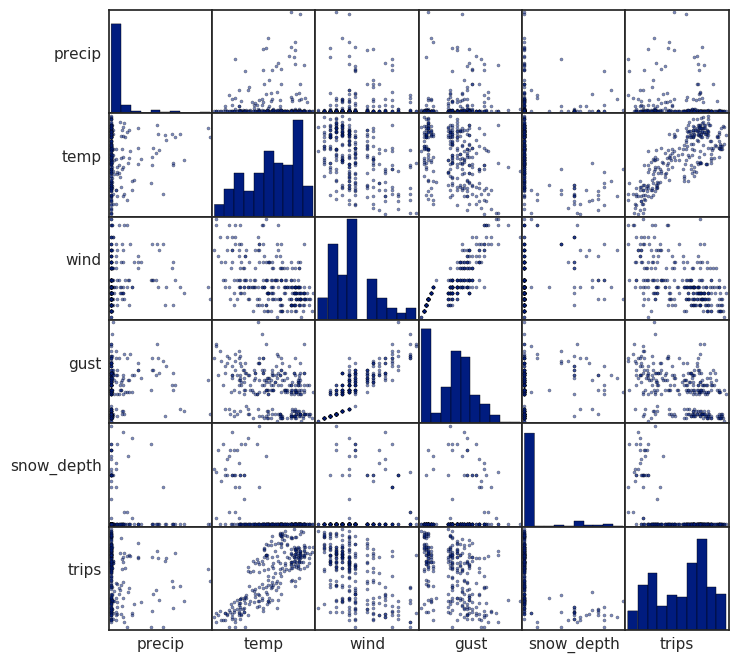

In [162]:
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('dark')

plot_data = trips_weather[Xcol + ['trips']]

# sns.pairplot(plot_data)
axs = pd.scatter_matrix(plot_data, figsize=(8, 8))

# Rotate axis labels and remove axis ticks 
n = len(plot_data.columns)
for i in range(n): 
    v = axs[i, 0] 
    v.yaxis.label.set_rotation(0) 
    v.yaxis.label.set_ha('right') 
    v.set_yticks(()) 
    h = axs[n-1, i] 
    h.xaxis.label.set_rotation(0) 
    h.set_xticks(())

Tempearture is strongly positively correlated with the number of trips. Wind appears to be (somewhat) negatively correlated. Presumably precipitation and snow are as well, but these correlations are likely too negative to see on the scale above.

Counts are being predicted here, so Poisson regression is one possibility. If an approach with more machine learning is desired, random forest regression and similar methods could be used. See discussion at the end of question regarding appropriateness.

Let's start with Poisson regression and then try machine learning methods.

In [163]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [164]:
train, test = train_test_split(trips_weather, test_size=0.3, random_state=42)

Xtrain = train[Xcol]
Ytrain = train['trips']
Xtest  = test[Xcol]
Ytest  = test['trips']

# none of the regression methods used below require normalization of input data

### Poisson regression of trips per day

Model daily trips with Poisson regression.

In [165]:
# Poisson regression
# Note that offset/exposure is not needed because
# the length of time (per day) is the same in each case

# Either of these two methods work for formula and data

# method 1--log is explicitly taken of y-data
# poisson_train = pd.concat([np.log(Ytrain), Xtrain], axis=1)
# formula = 'trips~' + '+'.join(Xcol)

# method 2--log is in equation
poisson_train = pd.concat([Ytrain, Xtrain], axis=1)
formula = 'np.log(trips)~' + '+'.join(Xcol)# + '-1' # fit is better with intercept present

# GLM model
model_PR1 = smf.glm(formula, 
                data=poisson_train, 
                family=sm.families.Poisson(link=sm.families.links.log))

# maximum likelihood model
model_PR2 = smf.poisson(formula, 
                        data=poisson_train)

results_PR1 = model_PR1.fit()
results_PR2 = model_PR2.fit()

Optimization terminated successfully.
         Current function value: 2.083794
         Iterations 13


Both methods produce essentially the same results. Looking at the coefficients and comparing to the pairplot above, it makes sense that temperature is postively correlated with number of trips while precipitation, wind, wind gusts, and snow depth are negatively correlated.

In [166]:
results_PR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          np.log(trips)   No. Observations:                  182
Model:                            GLM   Df Residuals:                      176
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -379.25
Date:                Mon, 12 Dec 2016   Deviance:                       2.0076
Time:                        01:41:41   Pearson chi2:                     1.98
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.2175      0.169     13.156      0.000         1.887     2.548
precip        -0.0170      0.046     -0.371      0.711        -0.107     0.073
temp           0.0020      0.002      1.242      0.214        -0.001     0.005
wind          -0.0030      0.013     -0.229      0.819        -0.029     0.023
gust          -0.0001      0.005     -0.025      0.980        -0.010     0.010
snow_depth    -0.0049      0.008     -0.607      0.544        -0.021     0.011
==============================================================================
"""

In [167]:
results_PR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:          np.log(trips)   No. Observations:                  182
Model:                        Poisson   Df Residuals:                      176
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Dec 2016   Pseudo R-squ.:                0.007963
Time:                        01:41:43   Log-Likelihood:                -379.25
converged:                       True   LL-Null:                       -382.29
                                        LLR p-value:                    0.2977
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.2175      0.169     13.156      0.000         1.887     2.548
precip        -0.0170      0.046     -0.371      0.711        -0.107     0.073
temp           0.0020      0.002      1.242      0.214        -0.001     0.005
wind          -0.0030      0.013     -0.229      0.819        -0.029     0.023
gust          -0.0001      0.005     -0.025      0.980        -0.010     0.010
snow_depth    -0.0049      0.008     -0.607      0.544        -0.021     0.011
==============================================================================
"""

Predict the daily trips for one of the two Poisson models.

In [176]:
# predict the counts for one of the two models above
Ypred_PR = results_PR1.predict(exog=Xtest)
Ypred_PR = np.exp(Ypred_PR)

In [177]:
# we will use this value later to compare models
results_PR1.pearson_chi2

1.9834420076452002

Visualize results of Poisson regression.

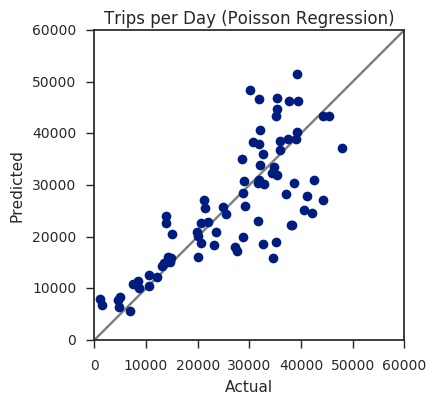

In [178]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('ticks')

f = plt.figure(figsize=(4,4))
ax = plt.axes()

ax.plot(Ytest, Ypred_PR, marker='o', ls='')
ax.plot([0,60000],[0,60000], marker='', ls='-', 
        color='gray', zorder=-1)
xlim = ax.get_xlim()
ax.set_ylim(xlim)

_ = ax.set(xlabel='Actual', ylabel='Predicted', 
           title='Trips per Day (Poisson Regression)')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

### Error analysis using $\chi^2$ and mean squared error

It is rather difficult to find a good error metric to compare Poisson distributions to the machine learning regression methods used below. Here, we have attempted to use mean squared error and a chi-squared test. Mean squared error is generally not used for Poisson regression, although in situations where the mean is very large, this is probably less of an issue.

In [188]:
from sklearn.metrics import mean_squared_error
from scipy.stats import chisquare

In [189]:
results_list = list()

# add Poisson Regression data
chi2 = chisquare(Ytest, Ypred_PR, ddof=1)
results_list.append(pd.Series({'name':'Poisson Regression', 
                               'pred':Ypred_PR,
                               'mse': mean_squared_error(Ytest, Ypred_PR),
                               'chi2': chi2[0],
                               'p-value': chi2[1]}))

results_list[0]

chi2                                                  200683
mse                                               6.2266e+07
name                                      Poisson Regression
p-value                                                    0
pred       [10390.2863846, 46780.2954506, 40164.8121083, ...
dtype: object

### Regression with machine learning

Regression with Random Forest, AdaBoost, and Gradient Boosted Trees.

In [190]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [191]:
# setup grid searches for bagging and boosting models

param_grids = {'Random Forest': {'n_estimators':[100, 200, 300, 400], 
                      'max_depth':[2,3,4,5,6]},
               'AdaBoost': {'n_estimators':[50, 75, 100], 
                      'learning_rate':[0.001, 0.01, 0.1],
                      'base_estimator':[DecisionTreeRegressor(max_depth=2),
                                        DecisionTreeRegressor(max_depth=3),
                                        DecisionTreeRegressor(max_depth=4)]},
               'Gradient Boosting': {'n_estimators':[25, 50, 75, 100], 
                      'learning_rate':[0.001, 0.01, 0.1, 1.0],
                      'max_depth':[2,3,4,5,6]}}

regressors = {'Random Forest': RandomForestRegressor(n_jobs=-1, 
                                          random_state=42, 
                                          verbose=0, 
                                          oob_score=True),
              'AdaBoost': AdaBoostRegressor(random_state=42),
              'Gradient Boosting': GradientBoostingRegressor(random_state=42, 
                                              verbose=0)}

# fit models
for name in ['Random Forest', 'AdaBoost', 'Gradient Boosting']:
    method = regressors[name]
    grid = GridSearchCV(method, param_grids[name], n_jobs=-1,
                        scoring='neg_mean_squared_error')
    grid.fit(Xtrain, Ytrain)
    Ypred = grid.predict(Xtest)
    mse = mean_squared_error(Ytest, Ypred)
    chi2 = chisquare(Ytest, Ypred, ddof=1)
    
    df = pd.Series({'name':name, 'grid':grid, 'pred':Ypred, 
                    'mse':mse, 'chi2':chi2[0], 'p-value':chi2[1]})
    results_list.append(df)

# compile results
results = pd.concat(results_list, axis=1).T.set_index('name')

# mean squared errors
results[['mse', 'chi2', 'p-value']]

,mse,chi2,p-value
name,,,
Poisson Regression,6.2266e+07,200683,0
Random Forest,4.17821e+07,133207,0
AdaBoost,4.0646e+07,129870,0
Gradient Boosting,4.1789e+07,134677,0


In [192]:
# dataframe for plotting
pred_df = pd.DataFrame(dict(zip(results.index, results.pred)))
pred_df['Poisson Regression'] = Ypred_PR
pred_df['Actual'] = Ytest.reset_index(drop=True)

# residuals
cols = ['Poisson Regression', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
resid_df = pred_df.copy()
resid_df[cols] = resid_df[cols].sub(resid_df.Actual, axis='rows')

pred_df.head(3)

,AdaBoost,Gradient Boosting,Poisson Regression,Random Forest,Actual
0,8211.266667,10565.166887,10390.286385,8537.002998,10586
1,36328.488889,35864.436446,46780.295451,36735.957351,35259
2,36328.488889,35446.064375,40164.812108,36712.863435,39255


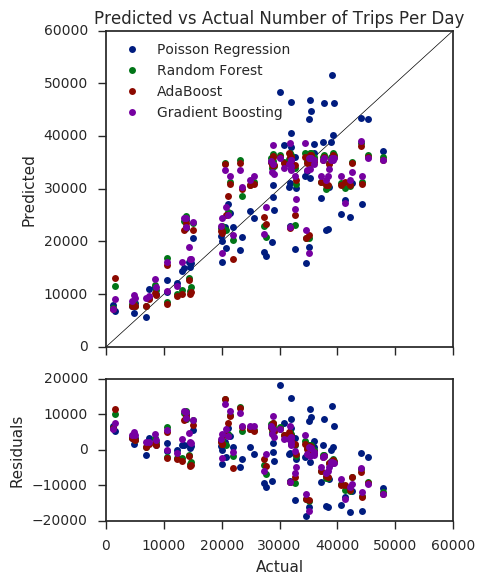

In [193]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('ticks')

fig = plt.figure(figsize=(5,6))
ax1 = plt.subplot2grid((3, 1), (0,0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2,0))

# predicted vs actual plot
ax = ax1
_ = pred_df.plot('Actual', 
                 ['Poisson Regression', 'Random Forest', 'AdaBoost', 'Gradient Boosting'], 
                 marker='o', ms=5.0, ls='', ax=ax)

minval = min(ax.get_xlim()[0], ax.get_ylim()[0])
maxval = max(ax.get_xlim()[1], ax.get_ylim()[1])

ax.set_xlim(minval, maxval)
ax.set_ylim(minval, maxval)

ax.plot([minval, maxval], [minval, maxval], 
        marker='', ls='-', color='black', 
        zorder=-1, lw=0.5)

_ = ax.set(ylabel='Predicted', 
           title='Predicted vs Actual Number of Trips Per Day',
           xlabel='')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

# residual plot
ax = ax2
_ = resid_df.plot('Actual', 
                 ['Poisson Regression', 'Random Forest', 'AdaBoost', 'Gradient Boosting'], 
                 marker='o', ms=5.0, ls='', ax=ax, legend=False)

_ = ax.set_yticks([-20000, -10000, 0, 10000, 20000])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim(minval, maxval)
ax.set_ylabel('Residuals')

plt.tight_layout()
fig.savefig('figures/q5_model_predictions.png', dpi=300, transparent=True)

<a id='q5_actual_v_predicted_plot'></a>
As this is count data, the use of appropriate methods (e.g. Poisson regression) is more appropriate than machine learning regression methods designed for continuous data (Random Forest, AdaBoost, Gradient Boosting), from a statistical standpoint. However, in practice, machine learning methods are often used. 

The residual distribution is definitely non-random, paritcularly for the machine learning models. Additional features and/or more data might improve this result. 

<a id='question6'></a>
## Question 6
[*Return to Introduction*](#introduction)
> * Using the tool of your preference, develop a visualization that displays something interesting about the data.

I have created a visualization that shows the flow of traffic into Manhattan during the weekday morning commute hours.
The plot uses the New York City shape files from [here](http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page) (and [direct file download](http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nybb_16d.zip)) for the borough boundaries.

In [62]:
import geopandas as gp

The total number of weekday trips originating and ending at a given station during the morning commute.

In [63]:
def select_start_stop(data, station_data, lab1, lab2):
    
    output = data.loc[data[lab1+'weekday'], [lab2+' station id', lab1+'hour']]

    # group and select only the morning and evening commute hours
    morning = (output[lab1+'hour'] >=  7)&(output[lab1+'hour'] <= 10)
    evening = (output[lab1+'hour'] >= 16)&(output[lab1+'hour'] <= 20)

    output['commute'] = np.NaN
    output.loc[morning,'commute'] = 'morning'
    output.loc[evening,'commute'] = 'evening'

    output = (output[[lab2+' station id', 'commute']]
                      .groupby([lab2+' station id', 'commute'])
                      .size()
                      .reset_index()
                      .rename(columns={0:'count'})
                      .rename_axis(lambda x: x.replace(lab2+' station ',''), axis=1))

    output = (pd.merge(output,
                       station_data[['id','latitude','longitude']],
                       on='id'))

    output['count'] = np.sqrt(output['count'])
    
    return output

# run the above function for origin and destination stations
start_stations = select_start_stop(data2, stations, 'start', 'start')
stop_stations = select_start_stop(data2, stations, 'stop', 'end')

start_stations.head(2)

,id,commute,count,latitude,longitude
0,72,evening,79.410327,40.767272,-73.993929
1,72,morning,81.351091,40.767272,-73.993929


Make plots of the weekday morning trip origin and destination.

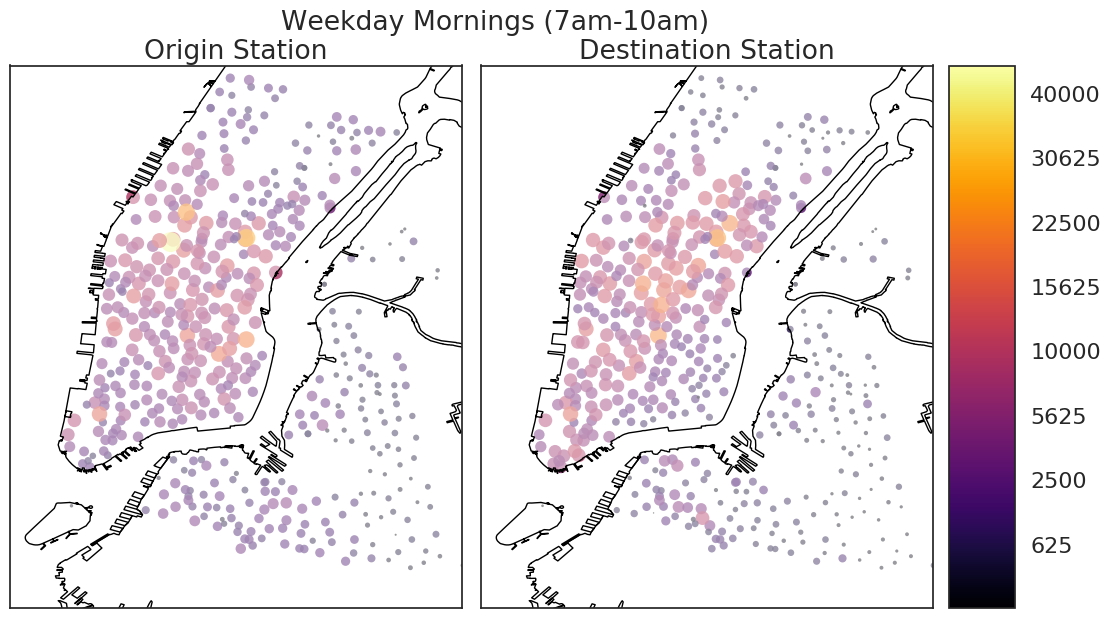

In [66]:
# read shapefile for NYC borough boundaries
nyc = gp.read_file('./nybb_16d/nybb.shp')
nyc = nyc.to_crs({'init': 'epsg:4326'})

# zoom region in latitude/longitude
lat_min = 40.67
lat_max = 40.79
lng_min = -74.03
lng_max = -73.93

# plot settings
sns.set_style('white')
sns.set_context('poster')

fig = plt.figure(figsize=(13, 7))
ax1 = plt.subplot2grid((1, 13), (0,0), colspan=6)
ax2 = plt.subplot2grid((1, 13), (0,6), colspan=6)
ax3 = plt.subplot2grid((1, 13), (0,12))
axList = [ax1, ax2]

cmap = plt.get_cmap('inferno')
all_data = np.r_[start_stations['count'], 
                        stop_stations['count']]
vmin = all_data.min()
vmax = all_data.max()

# plot specific settings
hour_list = ['commute=="morning"', 'commute=="morning"'] 
data_list = [start_stations, stop_stations]

# the plots
for ax,hour,data in zip(axList, hour_list, data_list):
    
    nyc.plot(color='white', ax=ax)
    
    ax.scatter(data.query(hour)['longitude'],
               data.query(hour)['latitude'],
               marker='o', edgecolor='None',
               c=data.query(hour)['count'], 
               s=data.query(hour)['count'], 
               cmap=cmap, vmin=vmin, vmax=vmax,
               alpha=0.8)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_aspect('equal')
    ax.set_xlim(lng_min, lng_max)
    ax.set_ylim(lat_min, lat_max)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm, spacing='proprotional')
# fix colorbar numbers since I took a square root to improve distribution colors
_ = ax3.set_yticklabels([int(float(x.get_text())**2) for x in ax3.get_yticklabels()])

_ = axList[0].set_title('Origin Station')
_ = axList[1].set_title('Destination Station')
_ = fig.suptitle('Weekday Mornings (7am-10am)')

# plt.tight_layout()
fig.savefig('figures/q6_weekday_morning_trips.png', dpi=300, transparent=True)

<a id='q6_orig_dest_plot'></a>

The visualization shows a much greater number of trips conclude in Manhattan during weekday mornings. The visualization could be improved by animating it.